# 概要
- モンテカルロ木探索を実装する。

In [1]:
!python -m pip install --no-index --find-links=/kaggle/input/reversi-datasets/ creversi

Looking in links: /kaggle/input/reversi-datasets/
Processing /kaggle/input/reversi-datasets/creversi-0.0.1-cp310-cp310-manylinux_2_24_x86_64.whl


In [2]:
from creversi import *

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from copy import copy, deepcopy
import gc

import torch
import torch.nn as nn

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [71]:
def board_to_array(board, return_torch=False):
    """
    boardオブジェクトからndarrayに変換する関数。
    第1チャンネルは黒石の位置、第2チャンネルに白石の位置、第3チャンネルに空白の位置、
    第4チャンネルに合法手の位置、第5チャンネルに返せる石の個数、第6チャンネルに隅=1、
    第7チャンネルに1埋め、第8チャンネルに0埋め。
    """
    b = np.zeros((8,8,8), dtype=np.float32)
    board.piece_planes(b)
    if not board.turn:
        b = b[[1,0,2,3,4,5,6,7],:,:]
    b[2] = np.where(b[0]+b[1]==1, 0, 1)
    legal_moves = list(board.legal_moves)
    if legal_moves != [64]:
        n_returns = []
        for move in legal_moves:
            board_ = copy(board)
            n_before = board_.opponent_piece_num()
            board_.move(move)
            n_after = board_.piece_num()
            n_returns.append(n_before-n_after)
        tmp = np.zeros(64)
        tmp[legal_moves] = n_returns
        tmp = tmp.reshape(8,8)
        b[3] = np.where(tmp > 0,1,0)
        b[4] = tmp
    b[5] = np.array([1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.]).reshape(8,8)
    b[6] = 1
    if return_torch:
        return torch.from_numpy(b)
    return b

def board_to_array2(board, return_torch=False):
    """
    boardオブジェクトからndarrayに変換する関数(ValueNetwork用)。
    第1チャネルは黒石の位置、第2チャネルに白石の位置、第3チャネルに空白の位置、
    第4チャネルに合法手の位置、第5チャネルに返せる石の個数、第6チャネルに隅=1、
    第7チャネルに1埋め、第8チャネルに0埋め、第9チャネルに手番情報(黒番=0埋め、白番=1埋め)
    """
    b = np.zeros((9,8,8), dtype=np.float32)
    board.piece_planes(b)
    if not board.turn:
        b = b[[1,0,2,3,4,5,6,7,8],:,:]
        b[8] = 1
    b[2] = np.where(b[0]+b[1]==1, 0, 1)
    legal_moves = list(board.legal_moves)
    if legal_moves != [64]:
        n_returns = []
        for move in legal_moves:
            board_ = copy(board)
            n_before = board_.opponent_piece_num()
            board_.move(move)
            n_after = board_.piece_num()
            n_returns.append(n_before-n_after)
        tmp = np.zeros(64)
        tmp[legal_moves] = n_returns
        tmp = tmp.reshape(8,8)
        b[3] = np.where(tmp > 0,1,0)
        b[4] = tmp
    b[5] = np.array([1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.]).reshape(8,8)
    b[6] = 1
    if return_torch:
        return torch.from_numpy(b)
    return b

# ネットワーク

In [70]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        n_filters = 100
        self.input_layer = nn.Sequential(
            nn.Conv2d(8,n_filters,kernel_size=5,padding=2),
            nn.ReLU()
        )
        self.hidden_layer = nn.Sequential(
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU()
        )
        self.output_layer = nn.Sequential(
            nn.Conv2d(n_filters,1,kernel_size=1),
            nn.Flatten()
        )
        
    def forward(self,x):
        out = self.input_layer(x)
        out = self.hidden_layer(out)
        out = self.output_layer(out)
        return out
    
class ValueNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        n_filters = 10
        self.input_layer = nn.Sequential(
            nn.Conv2d(9,n_filters,kernel_size=5,padding=2),
            nn.ReLU()
        )
        self.hidden_layer = nn.Sequential(
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.Conv2d(n_filters,n_filters,kernel_size=1,padding=1),
            nn.Flatten()
        )
        self.output_layer = nn.Sequential(
            nn.Linear(n_filters*100, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self,x):
        out = self.input_layer(x)
        out = self.hidden_layer(out)
        out = self.output_layer(out)
        return out.tanh()

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [72]:
model = torch.load('/kaggle/input/reversi-datasets/SL-PolicyNetwork-v3-checkpoint-5epoch-subdata99.pth').to(device)
model_val = torch.load('/kaggle/input/reversi-datasets/ValueNetwork-v1-checkpoint-10-10.pth').to(device)

In [74]:
class Node:
    def __init__(self, state:str, turn:bool, depth:int, parent) -> None:
        self.state = state
        self.turn = turn
        self.depth = depth
        self.parent = parent
        self.children = []
        self.n = 0
        self.w = 0
    
    def calc_ucb(self) -> list:
        """UCB1を計算"""
        if self.n == 0:
            return np.inf
        else:
            t = sum([child.n for child in self.parent.children])
            return (self.w / self.n) + (2*np.log(t)/self.n)**0.5
    
    def playout(self) -> None:
        """プレイアウトを1回実施"""
        b = Board()
        b.set_line(self.state, self.turn)
        while not b.is_game_over():
            move = np.random.choice(list(b.legal_moves))
            b.move(move)
        result = b.diff_num() if b.turn==self.turn else -b.diff_num()
        self.n += 1
        if result > 0:
            self.w += 1
    
    def select(self):
        """UCB1最大の子ノードを選択"""
        ucb = [child.calc_ucb() for child in self.children]
        return self.children[np.argmax(ucb)]
        
    def expand(self) -> None:
        """新しい子ノードの展開＆1回ずつプレイアウトを実施"""
        b = Board()
        b.set_line(self.state, self.turn)
        for move in b.legal_moves:
            b_ = Board()
            b_.set_line(self.state, self.turn)
            b_.move(move)
            child = Node(b_.to_line(), b_.turn, self.depth+1, self)
            child.playout()
            self.children.append(child)
            
    def backup(self) -> None:
        """逆伝播"""
        self.parent.n += self.n
        self.parent.w += self.w

In [119]:
class Node2:
    def __init__(self, state:str, turn:bool, depth:int, parent, lam:float) -> None:
        self.state = state
        self.turn = turn
        self.depth = depth
        self.parent = parent
        self.lam = lam
        self.children = []
        self.Nr = 0
        self.Wr = 0
        self.Nv = 0
        self.Wv = 0
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_pol = torch.load('/kaggle/input/reversi-datasets/SL-PolicyNetwork-v3-checkpoint-5epoch-subdata99.pth').to(device)
        self.model_val = torch.load('/kaggle/input/reversi-datasets/ValueNetwork-v1-checkpoint-10-10.pth').to(device)
    
    def playout(self) -> None:
        """プレイアウトを1回実施"""
        b = Board()
        b.set_line(self.state, self.turn)
        self.Nv += 1
        with torch.no_grad():
            self.Wv += (self.model_val(board_to_array2(b,True).unsqueeze(0)).numpy()[0][0] + 1) / 2
        while not b.is_game_over():
            move = np.random.choice(list(b.legal_moves))
            b.move(move)
        result = b.diff_num() if b.turn==self.turn else -b.diff_num()
        self.Nr += 1
        if result > 0:
            self.Wr += 1
    
    def select(self):
        """UCB1最大の子ノードを選択"""
        b = Board()
        b.set_line(self.state, self.turn)
        ucb = []
        for move,child in zip(b.legal_moves,self.children):
            Q = (1-self.lam)*child.Wv/child.Nv + self.lam*child.Wr/child.Nr
            with torch.no_grad():
                p = self.model_pol(board_to_array(b,True).unsqueeze(0)).softmax(dim=1).numpy()[0][move]
            u = p * np.sqrt(np.sum([child2.Nr for child2 in self.children])) / (1+child.Nr)
            ucb.append(Q+u)
        return self.children[np.argmax(ucb)]
        
    def expand(self) -> None:
        """新しい子ノードの展開＆1回ずつプレイアウトを実施"""
        b = Board()
        b.set_line(self.state, self.turn)
        for move in b.legal_moves:
            b_ = Board()
            b_.set_line(self.state, self.turn)
            b_.move(move)
            child = Node2(b_.to_line(), b_.turn, self.depth+1, self, self.lam)
            child.playout()
            self.children.append(child)
            
    def backup(self) -> None:
        """逆伝播"""
        self.parent.Nr += self.Nr
        self.parent.Wr += self.Wr
        self.parent.Nv += self.Nv
        self.parent.Wv += self.Wv

In [150]:
class Node3:
    def __init__(self, state:str, turn:bool, depth:int, parent) -> None:
        self.state = state
        self.turn = turn
        self.depth = depth
        self.parent = parent
        self.children = []
        self.Nr = 0
        self.Wr = 0
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_pol = torch.load('/kaggle/input/reversi-datasets/SL-PolicyNetwork-v3-checkpoint-5epoch-subdata99.pth').to(device)
    
    def playout(self) -> None:
        """プレイアウトを1回実施"""
        b = Board()
        b.set_line(self.state, self.turn)
        while not b.is_game_over():
            move = np.random.choice(list(b.legal_moves))
            b.move(move)
        result = b.diff_num() if b.turn==self.turn else -b.diff_num()
        self.Nr += 1
        if result > 0:
            self.Wr += 1
    
    def select(self):
        """UCB1最大の子ノードを選択"""
        b = Board()
        b.set_line(self.state, self.turn)
        ucb = []
        for move,child in zip(b.legal_moves,self.children):
            Q = child.Wr/child.Nr
            with torch.no_grad():
                if move != 64:
                    p = self.model_pol(board_to_array(b,True).unsqueeze(0)).softmax(dim=1).numpy()[0][move]
                else:
                    p = 1.0
            u = p * np.sqrt(np.sum([child2.Nr for child2 in self.children])) / (1+child.Nr)
            ucb.append(Q + u)
        return self.children[np.argmax(ucb)]
        
    def expand(self) -> None:
        """新しい子ノードの展開＆1回ずつプレイアウトを実施"""
        b = Board()
        b.set_line(self.state, self.turn)
        for move in b.legal_moves:
            b_ = Board()
            b_.set_line(self.state, self.turn)
            b_.move(move)
            child = Node3(b_.to_line(), b_.turn, self.depth+1, self)
            child.playout()
            self.children.append(child)
            
    def backup(self) -> None:
        """逆伝播"""
        self.parent.Nr += self.Nr
        self.parent.Wr += self.Wr

In [120]:
def MCTS(board, max_depth, n_thr):
    """モンテカルロ木探索の実行"""
    legal_moves = list(board.legal_moves)
    expand_children = []  # 展開されたノードを格納
    root = Node(board.to_line(), board.turn, 0, None)
    root.expand()
    while max([c.n for c in root.children]) < n_thr:
        child = root.select()
        child.playout()
    expand_child = root.children[np.argmax([c.n for c in root.children])]
    expand_child.expand()
    expand_children.append(expand_child)
      
    for d in range(max_depth):
        while max([c.n for c in expand_child.children]) < n_thr:
            child = expand_child.select()
            child.playout()
        expand_child.backup()
        expand_child = expand_child.children[np.argmax([c.n for c in expand_child.children])]
        if d < max_depth-1:
            expand_child.expand()
            expand_children.append(expand_child)
        
    for expand_child in reversed(expand_children):
        expand_child.backup()
        
    return legal_moves[np.argmax([c.w/c.n for c in root.children])]

In [145]:
def MCTS2(board, max_depth, n_thr, lam):
    """モンテカルロ木探索の実行"""
    legal_moves = list(board.legal_moves)
    expand_children = []  # 展開されたノードを格納
    root = Node2(board.to_line(), board.turn, 0, None, lam)
    root.expand()
    while max([c.Nr for c in root.children]) < n_thr:
        child = root.select()
        child.playout()
    expand_child = root.children[np.argmax([c.Nr for c in root.children])]
    expand_child.expand()
    expand_children.append(expand_child)
      
    for d in range(max_depth):
        while max([c.Nr for c in expand_child.children]) < n_thr:
            child = expand_child.select()
            child.playout()
        expand_child.backup()
        expand_child = expand_child.children[np.argmax([c.Nr for c in expand_child.children])]
        if d < max_depth-1:
            expand_child.expand()
            expand_children.append(expand_child)
        
    for expand_child in reversed(expand_children):
        expand_child.backup()
        
#     print([(1-c.lam)*c.Wv/c.Nv+c.lam*c.Wr/c.Nr for c in root.children])
    return legal_moves[np.argmax([(1-c.lam)*c.Wv/c.Nv+c.lam*c.Wr/c.Nr for c in root.children])]

In [151]:
def MCTS3(board, max_depth, n_thr):
    """モンテカルロ木探索の実行"""
    legal_moves = list(board.legal_moves)
    expand_children = []  # 展開されたノードを格納
    root = Node3(board.to_line(), board.turn, 0, None)
    root.expand()
    while max([c.Nr for c in root.children]) < n_thr:
        child = root.select()
        child.playout()
    expand_child = root.children[np.argmax([c.Nr for c in root.children])]
    expand_child.expand()
    expand_children.append(expand_child)
      
    for d in range(max_depth):
        while max([c.Nr for c in expand_child.children]) < n_thr:
            child = expand_child.select()
            child.playout()
        expand_child.backup()
        expand_child = expand_child.children[np.argmax([c.Nr for c in expand_child.children])]
        if d < max_depth-1:
            expand_child.expand()
            expand_children.append(expand_child)
        
    for expand_child in reversed(expand_children):
        expand_child.backup()
        
    print([c.Wr/c.Nr for c in root.children])
    return legal_moves[np.argmax([c.Wr/c.Nr for c in root.children])]

d3,e3,f2,c3,c5,c4,f3,f4,f5,b6,b3,g1,b5,a3,c2,e6,d7,g6,f6,d6,a4,g4,h3,g2,e2,b2,b4,a2,b1,g3,c6,d1,h6,a5,f1,b7,a6,f7,h1,e7,a8,a1,e8,g5,d2,f8,d8,h7,h2,h5,

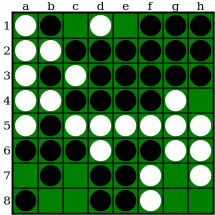

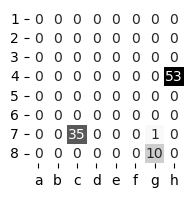

In [154]:
# 現在局面
board = Board()
for i in range(50):
    np.random.seed(i)
    move = np.random.choice(list(board.legal_moves))
    print(move_to_str(move),end=",")
    board.move(move)
display(board)

# SLポリシーネットワークの出力
prob = model(board_to_array(board, True).unsqueeze(0)).detach().softmax(dim=1).numpy().reshape(8,8) * 100
plt.figure(figsize=(2,2))
sns.heatmap(prob, annot=True, fmt='.0f', cmap='gray_r', cbar=False)
plt.xticks(ticks=np.arange(0.5,8.5),labels=list('abcdefgh'))
plt.yticks(ticks=np.arange(0.5,8.5),labels=list('12345678'),rotation=0)
plt.show()

In [156]:
move_to_str(MCTS3(board,2,100))

[0.39666666666666667, 0.4444444444444444, 0.0, 0.7647058823529411]


'g8'

e6
45.92%


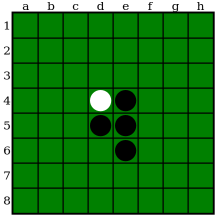

f4
47.15%


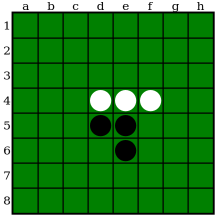

c3
45.43%


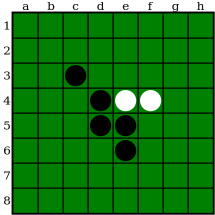

c4
43.73%


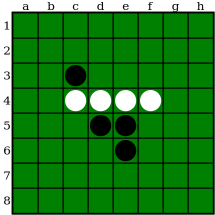

d3
44.42%


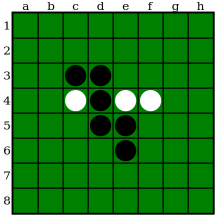

d6
42.13%


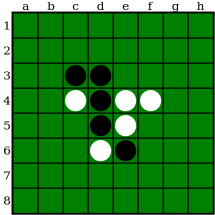

f6
43.15%


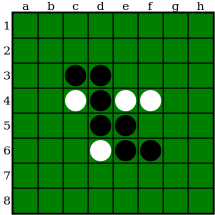

c6
43.99%


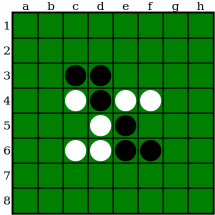

f5
41.88%


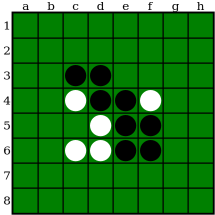

g5
46.99%


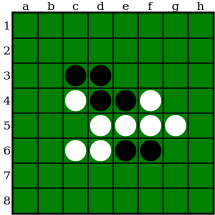

g4
43.54%


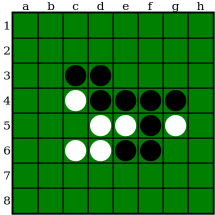

f7
48.06%


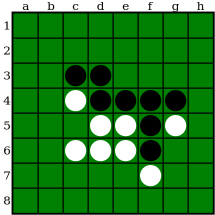

e7
46.32%


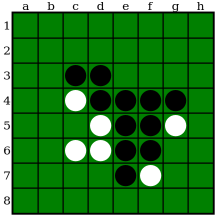

g6
47.04%


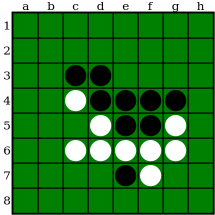

b5
43.30%


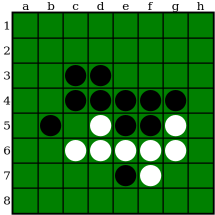

e3
44.07%


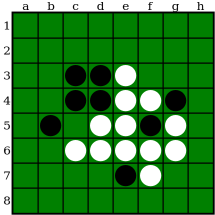

c5
43.05%


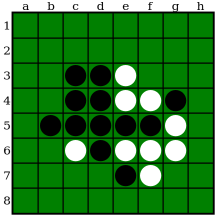

c7
48.23%


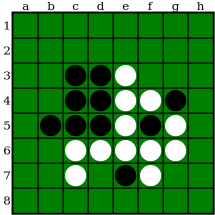

d7
45.62%


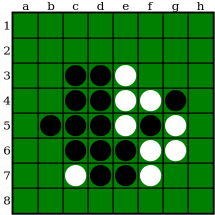

e8
45.23%


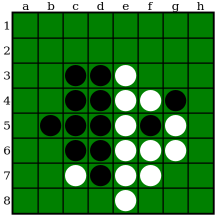

h6
47.01%


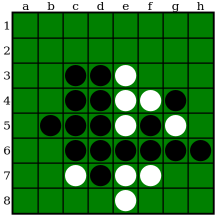

b4
53.64%


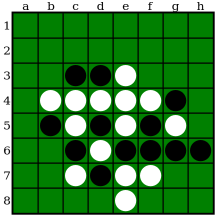

e2
47.21%


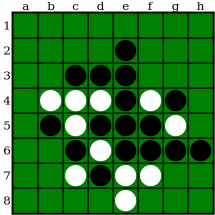

f2
50.83%


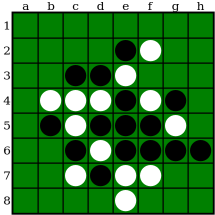

f3
48.17%


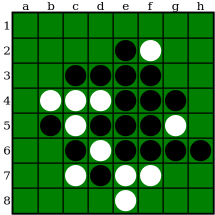

e1
54.97%


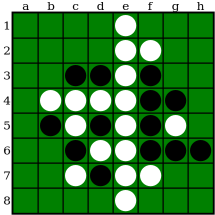

d2
46.17%


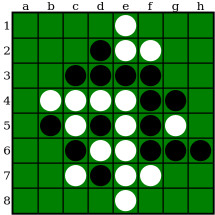

h3
45.23%


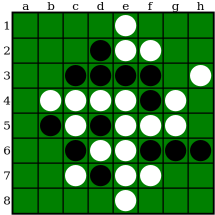

b6
37.20%


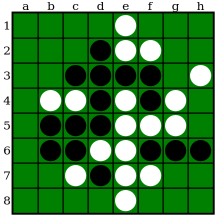

g3
24.13%


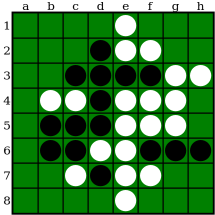

h4
27.97%


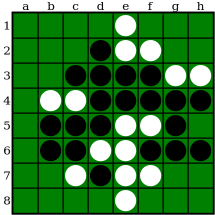

b3
34.90%


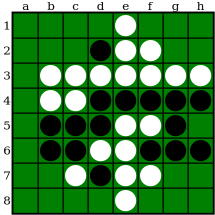

c2
40.13%


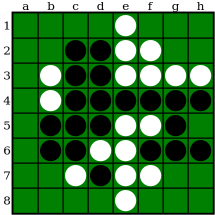

d8
44.69%


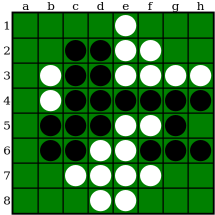

d1
33.34%


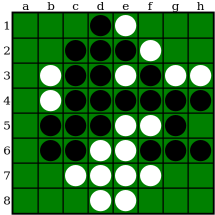

a6
52.31%


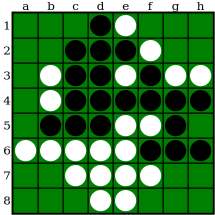

a5
43.27%


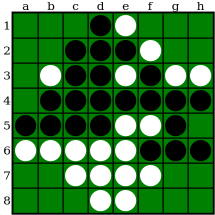

a4
43.49%


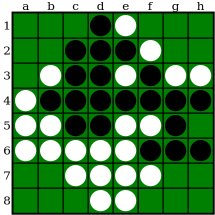

a3
56.97%


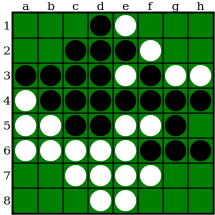

f1
52.94%


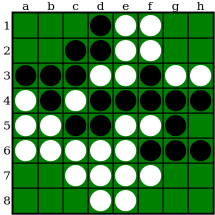

a7
28.09%


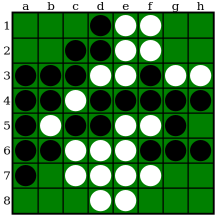

g2
87.09%


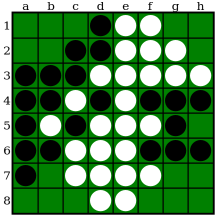

g8
63.73%


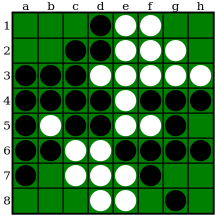

f8
86.72%


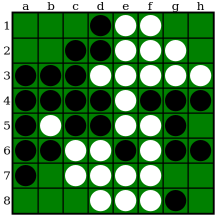

c8
94.09%


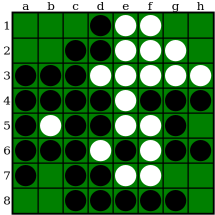

c1
97.29%


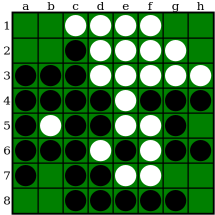

h1
96.96%


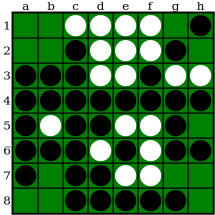

h2
96.71%


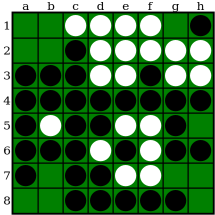

g1
98.30%


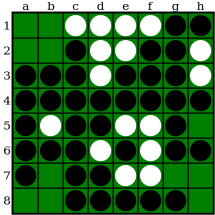

h5
96.19%


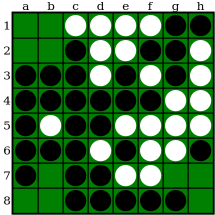

b1
89.64%


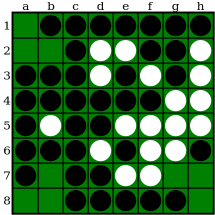

b2
95.55%


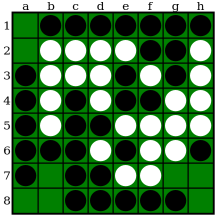

g7
17.99%


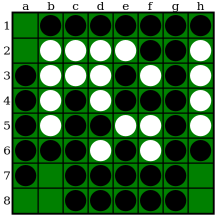

h8
93.43%


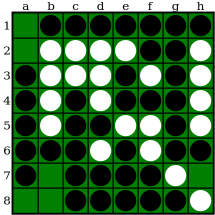

h7
97.83%


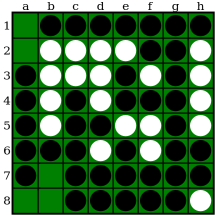

b8
78.33%


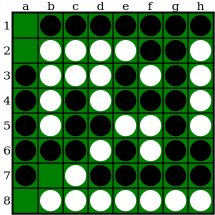

a1
97.00%


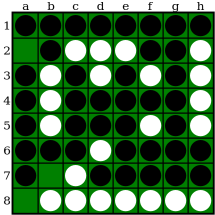

a2
97.49%


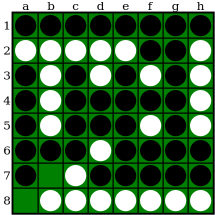

b7
96.04%


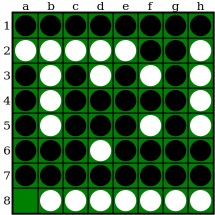

a8
5.86%


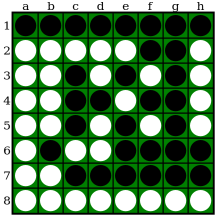

-2 True


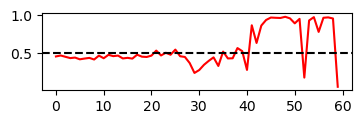

In [170]:
board = Board()
vs = []
while not board.is_game_over():
    if board.turn:
        if board.piece_num() + board.opponent_piece_num() > 100:
            move = MCTS3(board,2,100)
        else:
            with torch.no_grad():
                output = model(board_to_array(board, True).unsqueeze(0)).numpy()[0]
            legal_moves = list(board.legal_moves)
            if 64 not in legal_moves:
                move = legal_moves[output[legal_moves].argmax()]
            else:
                move = 64
    else:
#         move = np.random.choice(list(board.legal_moves))
        with torch.no_grad():
            output = model(board_to_array(board, True).unsqueeze(0)).numpy()[0]
        legal_moves = list(board.legal_moves)
        if 64 not in legal_moves:
            move = legal_moves[output[legal_moves].argmax()]
        else:
            move = 64
    board.move(move)
    print(move_to_str(move))
    v = (model_val(board_to_array2(board,True).unsqueeze(0))[0][0].item() + 1) / 2
    vs.append(v)
    print(f"{v*100:.2f}%")
    display(board)
print(board.diff_num(), board.turn)

plt.figure(figsize=(4,1))
plt.plot(vs, c='r')
plt.axhline(0.5, c='black', ls='--')
plt.show()

In [167]:
board.diff_num()

-2